## Bike Sharing Demand - Machine Learning v.5

- v.4까지의 결과로, `count`에 대해 예측하는 것과, month와 season 변수 중 `season`만 남기는 것이 가장 BEST 였음을 파악했다.
- 또한 windspeed 변수를 아예 삭제해버리는 것이 별로 성능이 좋지 않았다.
- 이번엔 windspeed의 수많은 0 값을 보완해서 성능 향상을 기대해보자.

## 1.Load the data
- EDA 편에서 확인한 결과 중복이나 결측치는 없었다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
#train data : target은 count 컬럼 
train = pd.read_csv('data/train.csv', parse_dates=['datetime'])
print(train.shape)
train.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
# test data
test = pd.read_csv('data/test.csv', parse_dates=['datetime'])
print(test.shape)
test.head()

(6493, 9)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


## 2. Preprocessing
#### 1) train data에서 필요한 열을 생성하자.
- month, casual, registered 제거

In [4]:
train['year'] = train['datetime'].dt.year
train['hour'] = train['datetime'].dt.hour
train['dayofweek'] = train['datetime'].dt.dayofweek

#불필요한 열 삭제
del train['datetime']
#casual, registered 삭제
del train['casual']
del train['registered']

train.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,hour,dayofweek
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,0,5
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,5
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,2,5


#### 2) weather ==4 아웃라이어 제거(1개 제거됨)

In [5]:
print('제거 전 ', len(train))
train = train.loc[train['weather'] !=4 ]
print('제거 후: ', len(train))

제거 전  10886
제거 후:  10885


#### 3) count 열의 아웃라이어 제거
- 3시그마를 초과하는 경우 제거

In [6]:
train = train[train['count'] - train['count'].mean() < 3*train['count'].std()]
train.reset_index(inplace =True, drop = True)
print(train.shape)
display(train.head())

(10738, 12)


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,hour,dayofweek
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,0,5
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,5
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,2,5
3,1,0,0,1,9.84,14.395,75,0.0,13,2011,3,5
4,1,0,0,1,9.84,14.395,75,0.0,1,2011,4,5


#### 4)count 변수에 로그변환

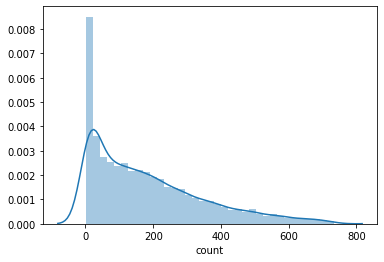

In [7]:
# casual & registered 의 분포 파악
sns.distplot(train['count'])

위의 그래프 모두 왼쪽으로 치우쳐져 있으므로, **로그변환**을 통해 target의 분포를 맞추자.

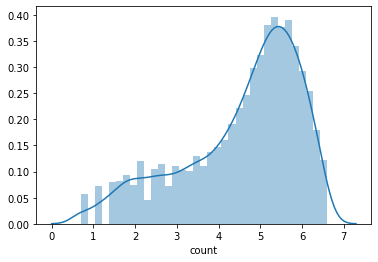

In [8]:
# 로그변환 후 
sns.distplot(np.log1p(train['count']))

완벽한 정규분포 형태는 아니지만, 좀 더 정규분포에 가까워졌으므로 이를 사용하기로 한다!

In [9]:
train['count'] = np.log1p(train['count'])

display(train.head())

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,hour,dayofweek
0,1,0,0,1,9.84,14.395,81,0.0,2.833213,2011,0,5
1,1,0,0,1,9.02,13.635,80,0.0,3.713572,2011,1,5
2,1,0,0,1,9.02,13.635,80,0.0,3.496508,2011,2,5
3,1,0,0,1,9.84,14.395,75,0.0,2.639057,2011,3,5
4,1,0,0,1,9.84,14.395,75,0.0,0.693147,2011,4,5


In [10]:
# skew(왜도) 확인 : +- 2 범위 안에 들어가므로 치우침이 없다고 볼 수 있음
print(train['count'].skew())

-0.8704448527723871


#### 5) 카테고리 변수 카테고리화

In [11]:
train.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,hour,dayofweek
0,1,0,0,1,9.84,14.395,81,0.0,2.833213,2011,0,5
1,1,0,0,1,9.02,13.635,80,0.0,3.713572,2011,1,5
2,1,0,0,1,9.02,13.635,80,0.0,3.496508,2011,2,5


In [12]:
cate_name = ['weather', 'season', 'year', 'hour', 'dayofweek', 'holiday', 'workingday']

for c in cate_name:
    train[c] = train[c].astype('category')
train.dtypes

season        category
holiday       category
workingday    category
weather       category
temp           float64
atemp          float64
humidity         int64
windspeed      float64
count          float64
year          category
hour          category
dayofweek     category
dtype: object

#### 6) (추가) windspeed 변수 결측치 채우기
- windspeed 변수의 많은 부분(12%)이 0으로 되어 있음.
- 진짜 풍속이 없어서일 수도 있지만, 결측치인데 0으로 되어 있을 가능성이 있으므로 이를 채워주자.

In [13]:
print('train data에서 windspeed 0의 비율:' , round((len(train.loc[train['windspeed']==0]) / len(train))*100 , 2), '%')
print('test data에서 windspeed 0의 비율:' , round((len(test.loc[test['windspeed']==0]) / len(test))*100 , 2), '%')

train data에서 windspeed 0의 비율: 12.08 %
test data에서 windspeed 0의 비율: 13.35 %


In [14]:
# windspeed의 분포 현황: 신기하게도 연속되어 있지 않다. 같은 값이 여러개 있다.. 
train.groupby('windspeed')['windspeed'].count()

windspeed
0.0000     1297
6.0032      865
7.0015     1027
8.9981     1109
11.0014    1037
12.9980    1027
15.0013     942
16.9979     807
19.0012     664
19.9995     486
22.0028     366
23.9994     272
26.0027     231
27.9993     187
30.0026     109
31.0009      89
32.9975      79
35.0008      56
36.9974      22
39.0007      26
40.9973      11
43.0006      12
43.9989       8
46.0022       3
47.9988       2
50.0021       1
51.9987       1
56.9969       2
Name: windspeed, dtype: int64

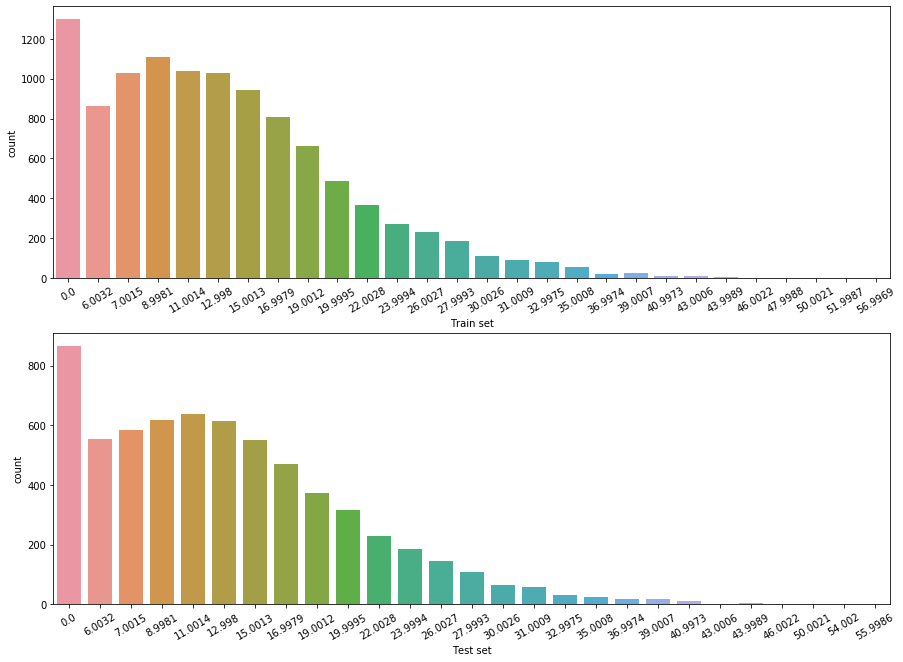

In [15]:
# 시각화
## 참고로, xticks를 ax1, ax2 각각에 설정할수가 없음. plt.sca로 ax를 설정하면 따로 plt.xticks에 ax 설정 안해도 된다
fig, axs = plt.subplots(2,1, figsize = (15, 11))
ax1, ax2 = axs.flatten()

plt.sca(ax = ax1)
sns.countplot(train['windspeed'], ax = ax1)
plt.xticks(rotation=30)

plt.sca(ax = ax2)
sns.countplot(test['windspeed'], ax = ax2)
plt.xticks(rotation=30)

ax1.set_xlabel('Train set')
ax2.set_xlabel('Test set')

plt.show()

#### train의 windspeed == 0인 부분에, 머신러닝을 활용해 0이 아닌 다른 값을 채우자!
- 방법: windspeed가 0이 아닌 데이터만 뽑아서, 이 데이터로 windspeed를 target으로 하여 학습을 시킨다.
- 이렇게 만들어진 모델을 활용해 windspeed가 0인 데이터만 뽑아 예측한다.
    - 근데 0이 너무 없으면 또 안돼서.... 6% 정도(절반)는 0을 그냥 냅두자.

In [17]:
train.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,hour,dayofweek
0,1,0,0,1,9.84,14.395,81,0.0,2.833213,2011,0,5
1,1,0,0,1,9.02,13.635,80,0.0,3.713572,2011,1,5
2,1,0,0,1,9.02,13.635,80,0.0,3.496508,2011,2,5


In [18]:
df = train.copy()
df_zero = df[df['windspeed'] == 0]
print(len(df_zero))

# 이 중에서 644개 정도는 그냥 0으로 둔다. sample 함수 사용 
df_zero_keep = df_zero.sample(round(len(train)*0.06), random_state = 99)
print(len(df_zero_keep))

1297
644


In [19]:
df_zero_keep.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,hour,dayofweek
3532,3,0,1,1,27.06,31.060,69,0.0,1.94591,2011,2,2
4658,4,0,1,1,13.12,17.425,93,0.0,1.94591,2011,4,0
4701,4,0,1,1,14.76,18.940,81,0.0,3.89182,2011,23,1


In [20]:
# 나머지만 예측에 필요한 것으로 가져오기
df_zero1 = df_zero.reset_index()
df_zero_keep1 = df_zero_keep.reset_index()

df_zero_use = df_zero1.loc[~df_zero1['index'].isin(df_zero_keep1['index'].tolist())]
df_zero_use.set_index(['index'], inplace = True)
print(len(df_zero_use))
display(df_zero_use.head(3))

653


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,hour,dayofweek
index,,,,,,,,,,,,
0,1,0,0,1,9.84,14.395,81,0.0,2.833213,2011,0,5
1,1,0,0,1,9.02,13.635,80,0.0,3.713572,2011,1,5
4,1,0,0,1,9.84,14.395,75,0.0,0.693147,2011,4,5


In [21]:
# 학습할 데이터셋
df_nonzero = df[df['windspeed'] != 0]
print(len(df_nonzero))

df_nonzero.dtypes

9441


season        category
holiday       category
workingday    category
weather       category
temp           float64
atemp          float64
humidity         int64
windspeed      float64
count          float64
year          category
hour          category
dayofweek     category
dtype: object

In [22]:
# 분류로 봐야하므로 df_nonzero의 windspeed 스트링으로 변경
df_nonzero['windspeed'] = df_nonzero['windspeed'].astype('str')
df_nonzero.dtypes

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


season        category
holiday       category
workingday    category
weather       category
temp           float64
atemp          float64
humidity         int64
windspeed       object
count          float64
year          category
hour          category
dayofweek     category
dtype: object

In [23]:
from sklearn.ensemble import RandomForestClassifier
# 모델
rf_wind = RandomForestClassifier()
# 학습
rf_wind.fit(df_nonzero[['season', 'weather', 'temp', 'atemp', 'humidity', 'year']], df_nonzero['windspeed'])
# 예측
pred = rf_wind.predict(df_zero_use[['season', 'weather', 'temp', 'atemp', 'humidity', 'year']])

In [24]:
# 새로운 데이터프레임 생성
df_zero_new = df_zero_use.copy()
df_zero_new['windspeed'] = pred
df_zero_new.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,hour,dayofweek
index,,,,,,,,,,,,
0,1,0,0,1,9.84,14.395,81,6.0032,2.833213,2011,0,5
1,1,0,0,1,9.02,13.635,80,6.0032,3.713572,2011,1,5
4,1,0,0,1,9.84,14.395,75,6.0032,0.693147,2011,4,5
6,1,0,0,1,9.02,13.635,80,6.0032,1.098612,2011,6,5
9,1,0,0,1,13.12,17.425,76,7.0015,2.708050,2011,9,5


In [25]:
# keep해뒀던 데이터프레임과 합침
pd.concat([df_zero_new, df_zero_keep], ignore_index = True)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,hour,dayofweek
0,1,0,0,1,9.84,14.395,81,6.0032,2.833213,2011,0,5
1,1,0,0,1,9.02,13.635,80,6.0032,3.713572,2011,1,5
2,1,0,0,1,9.84,14.395,75,6.0032,0.693147,2011,4,5
3,1,0,0,1,9.02,13.635,80,6.0032,1.098612,2011,6,5
4,1,0,0,1,13.12,17.425,76,7.0015,2.708050,2011,9,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1292,4,0,1,2,25.42,27.275,94,0.0,2.302585,2012,2,2
1293,3,0,1,2,35.26,37.120,30,0.0,6.442540,2012,18,1
1294,2,0,1,1,20.50,24.240,94,0.0,2.772589,2011,2,3
1295,4,0,0,2,16.40,20.455,94,0.0,5.093750,2012,23,5


In [26]:
# 위처럼 windspeed가 원래 0이 아니었던 df_nonzero와도 합침. 다시 train으로 저장
train = pd.concat([df_zero_new, df_zero_keep, df_nonzero], ignore_index = True)
print('train data에서 windspeed 0의 비율:' , round((len(train.loc[train['windspeed']==0]) / len(train))*100 , 2), '%')
display(train.head())

train data에서 windspeed 0의 비율: 6.0 %


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,hour,dayofweek
0,1,0,0,1,9.84,14.395,81,6.0032,2.833213,2011,0,5
1,1,0,0,1,9.02,13.635,80,6.0032,3.713572,2011,1,5
2,1,0,0,1,9.84,14.395,75,6.0032,0.693147,2011,4,5
3,1,0,0,1,9.02,13.635,80,6.0032,1.098612,2011,6,5
4,1,0,0,1,13.12,17.425,76,7.0015,2.708050,2011,9,5


In [27]:
# 다시 windspeed 값을 float로 변경 
train['windspeed'] = train['windspeed'].astype('float')
train.dtypes

season        category
holiday       category
workingday    category
weather       category
temp           float64
atemp          float64
humidity         int64
windspeed      float64
count          float64
year          category
hour          category
dayofweek     category
dtype: object

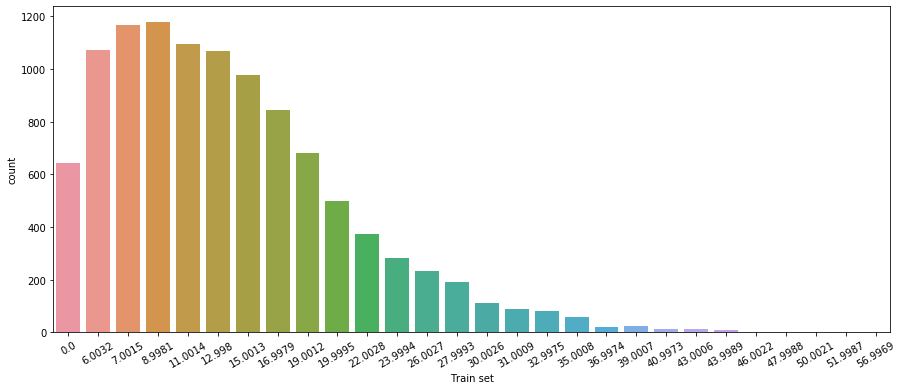

In [28]:
plt.figure(figsize = (15, 6))

sns.countplot(train['windspeed'])
plt.xticks(rotation=30)
plt.xlabel('Train set')

plt.show()

## 3. Modeling

- 참고로 지표 `RMSLE`는 target에 로그변환 시켰기 때문에 그냥 `RMSE`를 쓰면 된다.

In [29]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline

In [30]:
# X, y 나누기
X_df = train.drop(['count'], axis = 1) 
y_df = train['count']

#### 선형회귀 및 릿지

In [31]:
from sklearn.preprocessing import RobustScaler
#선형회귀 모델
lr_reg = LinearRegression()
#피처에 대해 표준화 진행과 k-fold를 함께 함
pipe = make_pipeline(RobustScaler(), lr_reg)
scores = cross_validate(pipe, X_df, y_df, cv=5, scoring='neg_mean_squared_error',return_train_score=True)
print("MSLE: {0:.3f}".format(np.mean(-scores['test_score']))) #디폴트가 음수라 -를 붙여야 제대로 된 결과가 나옴.

MSLE: 1.053


In [32]:
from sklearn.preprocessing import StandardScaler

#선형회귀 모델
lr_reg = LinearRegression()
#피처에 대해 표준화 진행과 k-fold를 함께 함
pipe = make_pipeline(StandardScaler(), lr_reg)
scores = cross_validate(pipe, X_df, y_df, cv=5, scoring='neg_mean_squared_error',return_train_score=True)
print("MSLE: {0:.3f}".format(np.mean(-scores['test_score']))) #디폴트가 음수라 -를 붙여야 제대로 된 결과가 나옴.

MSLE: 1.053


In [33]:
from sklearn.preprocessing import MinMaxScaler

#선형회귀 모델
lr_reg = LinearRegression()
#피처에 대해 표준화 진행과 k-fold를 함께 함
pipe = make_pipeline(MinMaxScaler(), lr_reg)
scores = cross_validate(pipe, X_df, y_df, cv=5, scoring='neg_mean_squared_error',return_train_score=True)
print("MSLE: {0:.3f}".format(np.mean(-scores['test_score']))) #디폴트가 음수라 -를 붙여야 제대로 된 결과가 나옴.

MSLE: 1.053


Ridge

In [34]:
#릿지
ridge_reg = Ridge()
pipe = make_pipeline(RobustScaler(), ridge_reg)
scores = cross_validate(ridge_reg, X_df, y_df, cv = 5, scoring='neg_mean_squared_error',return_train_score=True)
print("MSLE: {0:.3f}".format(np.mean(-scores['test_score']))) 

MSLE: 1.053


In [35]:
#릿지에 대해 하이퍼 파라미터 튜닝
pipeline = Pipeline([('scaler', RobustScaler()), ('ridge',Ridge())])
params={'ridge__alpha':[5, 10, 15, 20]}
grid_model = GridSearchCV(pipeline, param_grid=params, scoring='neg_mean_squared_error', cv=5)
grid_model.fit(X_df, y_df)
print("MSLE: {0:.3f}".format( -1*grid_model.best_score_)) 
print('optimal hyperparameter: ', grid_model.best_params_)

MSLE: 1.051
optimal hyperparameter:  {'ridge__alpha': 20}


In [36]:
#릿지에 대해 하이퍼 파라미터 튜닝
pipeline = Pipeline([('scaler', MinMaxScaler()), ('ridge',Ridge())])
params={'ridge__alpha':[5, 10, 15, 20]}
grid_model = GridSearchCV(pipeline, param_grid=params, scoring='neg_mean_squared_error', cv=5)
grid_model.fit(X_df, y_df)
print("MSLE: {0:.3f}".format( -1*grid_model.best_score_)) 
print('optimal hyperparameter: ', grid_model.best_params_)

MSLE: 1.051
optimal hyperparameter:  {'ridge__alpha': 5}


#### Tree model

In [37]:
#LGBM
lgbm = LGBMRegressor(n_estimators = 500, objective = 'regression')

#피처에 대해 표준화 진행과 k-fold를 함께 함
pipe = make_pipeline(MinMaxScaler(), lgbm)
scores = cross_validate(pipe, X_df, y_df, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
print("MSLE: {0:.3f}".format(np.mean(-scores['test_score']))) 

MSLE: 0.119


In [38]:
# estimators 늘려보기
lgbm = LGBMRegressor(n_estimators = 1000, objective = 'regression')

#피처에 대해 표준화 진행과 k-fold를 함께 함
pipe = make_pipeline(MinMaxScaler(), lgbm)
scores = cross_validate(pipe, X_df, y_df, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
print("MSLE: {0:.3f}".format(np.mean(-scores['test_score']))) 

MSLE: 0.123


In [39]:
#하이퍼 파라미터 튜닝
pipeline = Pipeline([('scaler', MinMaxScaler()), ('lgbm',LGBMRegressor(objective='regression'))])
params={'lgbm__learning_rate': [0.001, 0.01, 0.1],
       'lgbm__max_depth': [5, 10],
       'lgbm__reg_lambda':[0.1, 1],
       'lgbm__subsample': [0.5, 1],
       'lgbm__n_estimators': [300, 500]}
grid_model = GridSearchCV(pipeline, param_grid=params, scoring='neg_mean_squared_error', cv=5, n_jobs = 5, verbose=True)
grid_model.fit(X_df, y_df)
print("MSLE: {0:.3f}".format( -1*grid_model.best_score_)) 
print('optimal hyperparameter: ', grid_model.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   24.6s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.2min
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:  1.5min finished


MSLE: 0.112
optimal hyperparameter:  {'lgbm__learning_rate': 0.1, 'lgbm__max_depth': 5, 'lgbm__n_estimators': 300, 'lgbm__reg_lambda': 0.1, 'lgbm__subsample': 0.5}


In [40]:
#하이퍼 파라미터 튜닝
pipeline = Pipeline([('scaler', MinMaxScaler()), ('lgbm',LGBMRegressor(objective='regression', learning_rate = 0.1, subsample = 0.5))])
params={'lgbm__max_depth': [5, 7],
       'lgbm__reg_lambda':[0.1, 1],
       'lgbm__n_estimators': [200, 300]}
grid_model = GridSearchCV(pipeline, param_grid=params, scoring='neg_mean_squared_error', cv=5, n_jobs = 5, verbose=True)
grid_model.fit(X_df, y_df)
print("MSLE: {0:.3f}".format( -1*grid_model.best_score_)) 
print('optimal hyperparameter: ', grid_model.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 out of  40 | elapsed:    7.5s finished


MSLE: 0.111
optimal hyperparameter:  {'lgbm__max_depth': 5, 'lgbm__n_estimators': 200, 'lgbm__reg_lambda': 0.1}


## 4. Predict Test data
만들어진 모델을 바탕으로 test data에 대해 예측해보자.

In [41]:
X_df.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek
0,1,0,0,1,9.84,14.395,81,6.0032,2011,0,5
1,1,0,0,1,9.02,13.635,80,6.0032,2011,1,5
2,1,0,0,1,9.84,14.395,75,6.0032,2011,4,5


In [42]:
test.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000


In [43]:
test['year'] = test['datetime'].dt.year
test['hour'] = test['datetime'].dt.hour
test['dayofweek'] = test['datetime'].dt.dayofweek
#datetime 삭제
del test['datetime']

test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek
0,1,0,1,1,10.66,11.365,56,26.0027,2011,0,3
1,1,0,1,1,10.66,13.635,56,0.0000,2011,1,3
2,1,0,1,1,10.66,13.635,56,0.0000,2011,2,3
3,1,0,1,1,10.66,12.880,56,11.0014,2011,3,3
4,1,0,1,1,10.66,12.880,56,11.0014,2011,4,3


In [44]:
#카테고리 변수 생성
cate_name = ['weather', 'season', 'year', 'hour','dayofweek', 'holiday', 'workingday']

for c in cate_name:
    test[c] = test[c].astype('category')
test.dtypes

season        category
holiday       category
workingday    category
weather       category
temp           float64
atemp          float64
humidity         int64
windspeed      float64
year          category
hour          category
dayofweek     category
dtype: object

### count 예측하기
- 사용 모델: `LGBM`

In [45]:
# 피처 표준화
minmax = MinMaxScaler()
minmax.fit(X_df) #훈련셋 모수 분포 저장
X_df_scaled = minmax.transform(X_df)
X_test_scaled = minmax.transform(test)

In [46]:
# 최종 파라미터 튜닝된 모델로 학습 
lgbm = LGBMRegressor(n_estimators = 300, objective = 'regression',
                    learning_rate = 0.1, max_depth = 5, reg_lambda = 0.1, subsample = 0.5, random_state = 99)

# 학습
lgbm.fit(X_df_scaled, y_df)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=5,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=300, n_jobs=-1, num_leaves=31,
              objective='regression', random_state=99, reg_alpha=0.0,
              reg_lambda=0.1, silent=True, subsample=0.5,
              subsample_for_bin=200000, subsample_freq=0)

In [47]:
# test에 대해 예측
pred = lgbm.predict(X_test_scaled)
fpred = np.expm1(pred) #로그변환 값을 풀어줌

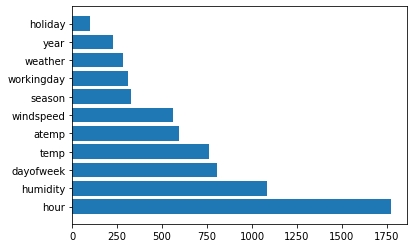

In [48]:
#lgbm 모델의 feature importance
imp = pd.DataFrame({'feature': test.columns, 
                                    'coefficient': lgbm.feature_importances_})
imp = imp.sort_values(by = 'coefficient', ascending = False)

plt.barh(imp['feature'], imp['coefficient'])
plt.show()

In [49]:
imp

,feature,coefficient
9,hour,1773
6,humidity,1083
10,dayofweek,805
4,temp,759
5,atemp,593
7,windspeed,562
0,season,326
2,workingday,311
3,weather,282
8,year,228


In [50]:
test['count'] = fpred
test.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,count
0,1,0,1,1,10.66,11.365,56,26.0027,2011,0,3,13.896492
1,1,0,1,1,10.66,13.635,56,0.0000,2011,1,3,5.601859
2,1,0,1,1,10.66,13.635,56,0.0000,2011,2,3,3.103480


In [51]:
# submission 가져오기 
sub = pd.read_csv('data/sampleSubmission.csv')
sub.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [52]:
del sub['count']

In [53]:
sub['count'] = test['count']
sub.head()

,datetime,count
0,2011-01-20 00:00:00,13.896492
1,2011-01-20 01:00:00,5.601859
2,2011-01-20 02:00:00,3.103480
3,2011-01-20 03:00:00,1.837175
4,2011-01-20 04:00:00,1.747261


In [54]:
sub.to_csv('Submission_sy_4.csv', index=False)

#### 최종 제출 결과: `Score: 0.37665`
가장 BEST 성능! 역시 test data의 windspeed에도 0이 많아서, train data의 windspeed에서 0의 값을 절반만 채워준 게 잘한 듯:)